# Generate a PPi train + validation set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action) and a Y2H test set from [HuRI](http://www.interactome-atlas.org/download)

`small size, 10:1, 31/10/22`

In [1]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

from pathlib import Path

from dataclasses import dataclass, field

import numpy as np
from dataclass_wizard import JSONWizard

In [2]:
!which python
!pwd

/home/k/kaindll/mambaforge/envs/ppi/bin/python
/home/k/kaindll


In [3]:
if 'kaindl' in str(cwd := Path.cwd()):
    cwd = Path('/home/k/kaindll/ppi/ppi_data/template')

In [4]:
session = '8001'
session_dir = cwd.parent / 'results' / session

if not session_dir.is_dir():
    shutil.copytree(cwd, session_dir, symlinks=False,
                    ignore=shutil.ignore_patterns('*.ipynb', '*.png'),
                    dirs_exist_ok=True)
os.chdir(session_dir.resolve())
!pwd

/home/k/kaindll/ppi/ppi_data/results/8001


In [5]:
from ppi_utils.cfg import Config, SamplingStrategy
from ppi_utils import api, extract, general, pairs, plot, reduce, proteome

from ppi_utils.api import *
from ppi_utils.extract import *
from ppi_utils.general import *
from ppi_utils.pairs import *
from ppi_utils.plot import *
from ppi_utils.reduce import *
from ppi_utils.proteome import *

In [6]:

@dataclass
class Params(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    accept_homodimers: bool = False
    add_proteomes: bool = True
    slurm: bool = all(shutil.which(t) for t in ('snakemake', 'sbatch'))
    slurm_node_limit: int = 15
    rostclust: bool = shutil.which('rostclust')

    min_seq_len: int = 50
    max_seq_len: int = 1000

    seed: int = 42
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: set[str] = field(default_factory=set)


hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

# val_species = {10116, 9913, 9031, 868565, 10299}
# train_species = {7955, 36329, 83333, 10090, 85962}
val_species = {7955, 9913, 9031, 868565, 10299, 39947, 10377, 224308}
train_species = {10116, 36329, 83333, 10090, 37296, 85962, 284812, 243276}

params = Params()

In [7]:
c = Config(
    **params.to_dict() | dict(
        hval_config=hval_config, val_species=val_species,
        train_species=train_species,
        cwd=session_dir, strategy=params.strategy
    ))

## Train set: APID
#### extract from `<taxid>*_Q1.txt` files

In [8]:
c.qp = unzip_apid(zip_path='apid.zip', keep_human=c.keep_human,
                  keep_interspecies=c.keep_interspecies)
c.qp

PosixPath('apid_q1')

In [9]:
uniprot_ids = extract_apid_uniprot_ids(c.qp)
len(uniprot_ids)

45026

In [10]:
ppis = extract_apid_ppis(c.qp)
len(ppis)

161598

In [11]:
ppis.head()

,UniprotID_A,UniprotID_B,species
0,Q0P8E9,Q0P8W0,192222
1,O52908,Q0PC70,192222
2,Q0P8F1,Q0PC72,192222
3,Q0P8E9,Q0P8F0,192222
4,P96747,Q0PAW7,192222


#### select small subset

In [12]:
if c.train_species:
    ppis = ppis.loc[ppis.species.isin(c.train_species | c.val_species)]
    uniprot_ids = set(np.unique(ppis.iloc[:, [0, 1]]))
len(ppis), len(uniprot_ids)

(23218, 12099)

In [13]:
find_multi_species_ppis(ppis)

,UniprotID_A,UniprotID_B,species


In [14]:
find_multi_species_proteins(ppis)

,UniprotID,species


#### download sequences

In [15]:
# skip if re-running this w/o changes above or deleting files
_ = uniprot_api_fetch(uniprot_ids, c.ap / 'apid')

jobId: 15dce1de0384945f653fcb0c53cc9b07bc87dae4
apid: query + tab ... 12099:0
apid: fasta ...


KeyboardInterrupt



#### map IDs to seq hashes

In [16]:
hash_ppis = ppis_to_hashes(ppis, c.ap / 'apid.json').drop_duplicates()
hash_ppis.head()

,hash_A,hash_B,species
1049,CRC-00097529ECAB0123,CRC-6C00626711C8012D,10090
122,CRC-000BC5DD420D0669,CRC-2808F51BBD3A8B6E,7955
184,CRC-0011BA5214873CAF,CRC-303501D8DA2E2440,39947
513,CRC-0014B58B77D0127B,CRC-915DCA04EF0B2902,10116
149,CRC-001980A1CC7646D7,CRC-A4E40D2CC1DE8F65,284812


In [17]:
len(ppis) - len(hash_ppis)

146

In [18]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ap / 'apid.hash.fasta', 'fasta'))
len(fasta)

11992

#### filter by seq length

In [19]:
c.min_seq_len, c.max_seq_len

(50, 1000)

dropped 4639/23072 PPIs from length filtering
dropped 0/9918 table IDs and 0/18433 rows, and 2074/11992 sequence IDs


(11992, 9918)

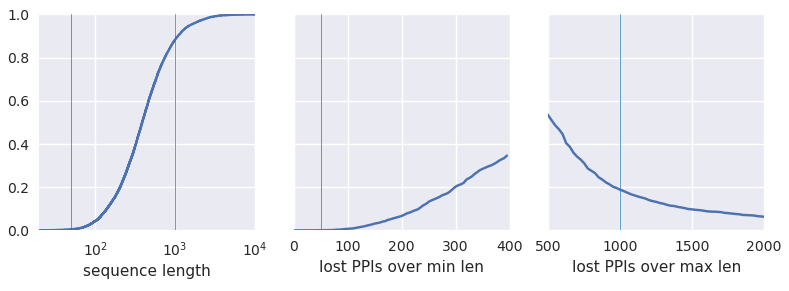

In [20]:
_hash_ppis, _fasta, _ = filter_ppis_and_fasta_by_len(
    hash_ppis, fasta, c.min_seq_len, c.max_seq_len)
len(fasta), len(_fasta)

continue if these limits were ok, or change/set the values for
`cfg.min_seq_len, cfg.max_seq_len` and re-run the filtering cell

In [21]:
hash_ppis = _hash_ppis
fasta = _fasta

#### homodimer share
Overall count, share, overall PPI count

In [23]:
%matplotlib inline

(False, 1284, 0.0697, 18433)

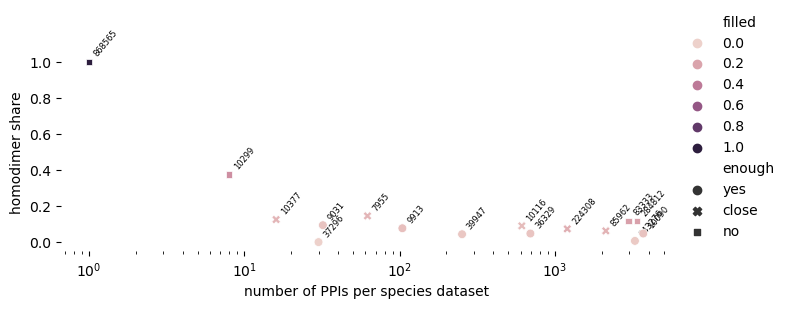

In [24]:
_ = plot_homodimer_share(hash_ppis)
c.accept_homodimers, *count_homodimers(hash_ppis),

In [25]:
if not c.accept_homodimers:
    hash_ppis = drop_homodimers(hash_ppis)
hash_ppis, fasta = shrink_both_ways(hash_ppis, fasta)
len(hash_ppis), len(fasta)

dropped 0/9615 table IDs and 0/17149 rows, and 303/9918 sequence IDs


(17149, 9615)

#### degree distributions
Look at some of those. In the next step, we will try to identify interactions between hubs and proteins that occur only once; and remove those PPIs. This will shrink the set of proteins and the degree of the hub; and we'll need less SwissProt proteins for it.

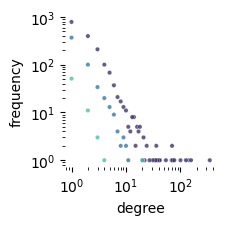

In [26]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degree_distribution(hash_ppis.loc[hash_ppis.species.isin(
        [7955, 10116, 284812])].copy(), 2.4)
    fg._legend.remove()
    for sfx in ['svg', 'png']:
        fg.savefig(f'degree_distrs.{sfx}', dpi=300)

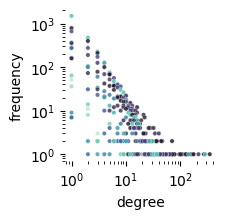

In [27]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degree_distribution(hash_ppis)
    fg._legend.remove()

#### remove proteins that only interact with an über-hub?
so that we need less extra proteins. Either directly remove hubs and hope that also drops a lot of proteins that interact only with them; or directly remove proteins that only interact with hubs.

First squint at numbers a bit: At what percentage do overkill-hubs start?

In [28]:
fetch_degrees(hash_ppis).groupby('species')['degree'].describe(percentiles=[.9, .95, .98])

,count,mean,std,min,50%,90%,95%,98%,max
species,,,,,,,,,
7955,67.0,1.582090,2.368667,1.0,1.0,2.0,3.00,3.68,20.0
9031,46.0,1.260870,0.534781,1.0,1.0,2.0,2.00,3.00,3.0
9913,94.0,2.042553,2.144836,1.0,1.0,5.0,7.00,8.14,12.0
10090,2631.0,2.676549,6.749672,1.0,1.0,5.0,8.00,14.00,285.0
10116,557.0,1.996409,6.085718,1.0,1.0,3.0,5.00,7.00,141.0
10299,8.0,1.250000,0.707107,1.0,1.0,1.6,2.30,2.72,3.0
10377,15.0,1.866667,1.302013,1.0,1.0,3.6,4.30,4.72,5.0
36329,536.0,2.466418,2.621049,1.0,1.0,5.0,7.00,12.30,24.0
37296,18.0,3.333333,2.656845,1.0,3.0,6.0,6.75,9.30,11.0


Fetch the node degrees and protein numbers

In [29]:
ppi_dgs = fetch_degrees(hash_ppis, as_dict=True)
p_dgs = fetch_n_proteins(hash_ppis).to_dict()
for ch, num in zip('AB', '01'):
    hash_ppis[f'degree_{num}'] = hash_ppis[f'hash_{ch}'].apply(ppi_dgs.get)

# sort the two columns of degrees
hash_ppis[['degree_0', 'degree_1']] = np.sort(
    hash_ppis[['degree_0', 'degree_1']], axis=1)
hash_ppis['n_seqs'] = hash_ppis.species.apply(p_dgs.get)
hash_ppis.head()

,hash_A,hash_B,species,minlen,maxlen,degree_0,degree_1,n_seqs
1049,CRC-00097529ECAB0123,CRC-6C00626711C8012D,10090,247,770,1,12,2631
122,CRC-000BC5DD420D0669,CRC-2808F51BBD3A8B6E,7955,264,363,1,1,67
184,CRC-0011BA5214873CAF,CRC-303501D8DA2E2440,39947,133,282,1,3,244
513,CRC-0014B58B77D0127B,CRC-915DCA04EF0B2902,10116,573,752,1,141,557
149,CRC-001980A1CC7646D7,CRC-A4E40D2CC1DE8F65,284812,305,838,1,2,1727


In [30]:
# find the pairs
greedy = 2
dppis = hash_ppis.loc[(hash_ppis.degree_0 == 1) & (hash_ppis.degree_1 >= hash_ppis.n_seqs / c.ratio / greedy)].copy()
len(dppis), len(hash_ppis), 'of pairs will drop ...'

(652, 17149, 'of pairs will drop ...')

In [31]:
_hash_ppis = hash_ppis.iloc[~hash_ppis.index.isin(dppis.index)].copy()
_hash_ppis, _fasta = shrink_both_ways(_hash_ppis, fasta.copy())
len(_hash_ppis), len(hash_ppis), len(_fasta), len(fasta)

dropped 0/8199 table IDs and 0/14008 rows, and 1416/9615 sequence IDs


(14008, 17149, 8199, 9615)

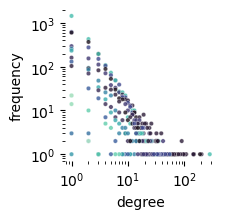

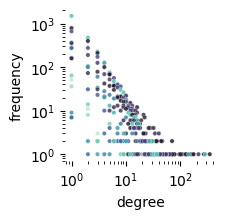

In [32]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degree_distribution(_hash_ppis, 2.4)
    fg._legend.remove()
    # the og one
    fg = plot_degree_distribution(hash_ppis, 2.4)
    fg._legend.remove()

In [33]:
if True:  # This is used now! of course off by default
    hash_ppis = _hash_ppis
    fasta = _fasta

#### species lookup

In [34]:
taxonomy = fetch_taxonomic_info(pd.concat((
    hash_ppis.species, pd.Series([9606] * 59251))
).rename('species')).sort_values(by='n_ppis')
taxonomy['set_name'] = ''
taxonomy.loc[~taxonomy.species.isin(c.val_species | {9606}), 'set_name'] += '_train'
taxonomy.loc[taxonomy.species.isin(c.val_species), 'set_name'] += '_validate'
taxonomy.loc[taxonomy.species == 9606, 'set_name'] = 'test'
taxonomy.set_name = taxonomy.set_name.str.lstrip('_')
taxonomy.loc[taxonomy.name.str.startswith('Campylob'), 'name'] = 'Campylobacter jejuni'
taxonomy.loc[taxonomy.name.str.startswith('Sever'), 'name'] = 'SARS-CoV 2'
taxonomy

100%|███████████████████████████████████████████| 15/15 [00:04<00:00,  3.16it/s]


,species,name,n_ppis,set_name
6,10377,Human herpesvirus 4 strain B95-8,4,validate
8,37296,Human gammaherpesvirus 8,6,train
1,9031,Gallus gallus,7,validate
0,7955,Danio rerio,13,validate
3,9913,Bos taurus,49,validate
9,39947,Oryza sativa Japonica Group,173,validate
5,10116,Rattus norvegicus,390,train
7,36329,Plasmodium falciparum 3D7,536,train
12,224308,Bacillus subtilis subsp. subtilis str. 168,752,validate
11,85962,Helicobacter pylori 26695,1612,train


In [35]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from ppi_utils.api import *
from ppi_utils.extract import *
from ppi_utils.general import *
from ppi_utils.pairs import *
from ppi_utils.plot import *
from ppi_utils.reduce import *
from ppi_utils.proteome import *

In [37]:
%matplotlib inline

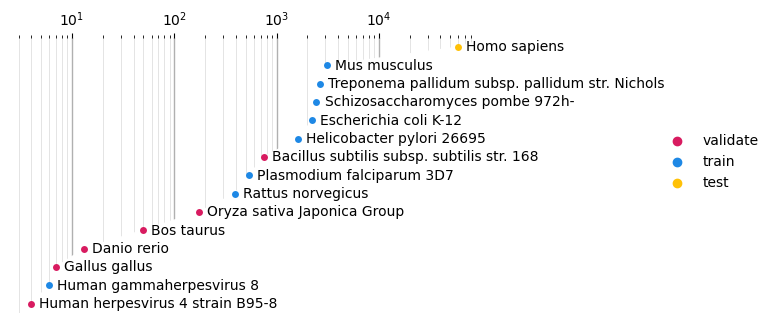

In [41]:
fi = plot_interactome_sizes(taxonomy, h=4.5, s=25)
for sfx in ['svg', 'png']:
    fi.savefig(f'interactome_sizes.{sfx}', dpi=300)

#### download proteomes

In [39]:
# skip if re-running this w/o changes above or deleting files
if c.add_proteomes:
    fetch_proteomes(set(taxonomy.species) | {9606}, c.pp)

100%|██████████████████████| 15/15 [02:53<00:00, 11.58s/it, batch=Gallus gallus]


## Validation set: APID
#### val: select species/proteins
Either by sampling a subset of proteins and selecting the PPIs or picking the ones for one or more particular species

In [42]:
c.val_set_size, c.val_species

(0.1, {7955, 9031, 9913, 10299, 10377, 39947, 224308, 868565})

In [43]:
taxonomy.loc[taxonomy.species.isin(c.val_species)]

,species,name,n_ppis,set_name
6,10377,Human herpesvirus 4 strain B95-8,4,validate
1,9031,Gallus gallus,7,validate
0,7955,Danio rerio,13,validate
3,9913,Bos taurus,49,validate
9,39947,Oryza sativa Japonica Group,173,validate
12,224308,Bacillus subtilis subsp. subtilis str. 168,752,validate


In [44]:
hash_ppis['label'] = 1
if c.val_species is not None:
    train, val = make_validation_species(hash_ppis, c.val_species)
else:
    # if the set becomes too large, try another seed!
    # With this approach, PPIs *will* be lost
    train, val = make_validation_split(hash_ppis, c.val_set_size, c.seed)
c.val_species = set(val.species)
c.train_species = set(train.species)
len(train), len(train) / len(hash_ppis), len(val), len(val) / len(hash_ppis)

(13010, 0.9287549971444888, 994, 0.07095945174186179)

In [45]:
val.head()

,hash_A,hash_B,species,minlen,maxlen,degree_0,degree_1,n_seqs,label
122,CRC-000BC5DD420D0669,CRC-2808F51BBD3A8B6E,7955,264,363,1,1,67,1
184,CRC-0011BA5214873CAF,CRC-303501D8DA2E2440,39947,133,282,1,3,244,1
1139,CRC-0038A2491FC5A50F,CRC-62AD6CA7294E1FAA,224308,218,334,2,214,579,1
942,CRC-0038A2491FC5A50F,CRC-7C00301A62188306,224308,196,218,2,19,579,1
113,CRC-00610BF36473BB97,CRC-161E9B04CFC5A1D7,9913,542,556,2,7,94,1


In [46]:
val.species.unique(), train.species.unique()

(array([  7955,  39947, 224308,   9913,   9031,  10377]),
 array([ 10090, 284812,  83333,  36329, 243276,  85962,  10116,  37296]))

Separate the validation set sequences from the ones remaining as train set

#### train: save seqs + positives


In [47]:
_, train_seqs = shrink_both_ways(train.copy(), fasta.copy())
c.train_seqs = len(train_seqs)
len(train_seqs), len(fasta)

dropped 0/7569 table IDs and 0/13010 rows, and 630/8199 sequence IDs


(7569, 8199)

In [48]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_raw_fasta, 'fasta')
train.to_csv(c.train_raw_tsv, sep='\t', header=True, index=False)
c.train_raw_fasta, c.train_raw_tsv

(PosixPath('apid/apid_train_raw.fasta'), PosixPath('apid/apid_train_raw.tsv'))

#### val: save seqs + positives

In [49]:
_, val_seqs = shrink_both_ways(val.copy(), fasta.copy())
len(val_seqs), len(fasta)

dropped 0/628 table IDs and 0/994 rows, and 7571/8199 sequence IDs


(628, 8199)

In [50]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_raw_fasta, 'fasta')
val.to_csv(c.val_raw_tsv, sep='\t', header=True, index=False)
c.val_raw_fasta, c.val_raw_tsv

(PosixPath('apid/apid_validation_raw.fasta'),
 PosixPath('apid/apid_validation_raw.tsv'))

Mind that the TSVs will contain only positives! Sample negatives only after most of the `uniqueprot`-shebang.

## Test set: HuRI
#### download and extract PPIs

In [51]:
c.psi_path

PosixPath('hi_union.psi')

In [52]:
# it's somehow a lot faster to download this from a browser!
# or run !wget "http://www.interactome-atlas.org/data/HI-union.psi" -O "hi_union.psi"
download_y2h_interactome(c.psi_path)

already downloaded and SHA256 checks out


PosixPath('hi_union.psi')

In [53]:
huri_ppis, huri_seq_ids = extract_huri_ppis(c.psi_path)
len(huri_ppis)

97888

#### pick a subset?

In [54]:
frac = 6
huri_ids = np.unique(huri_ppis.iloc[:, [0, 1]])
len(train), len(val), len(val_seqs) + len(train_seqs) + len(huri_ids) // frac

(13010, 994, 9770)

In [55]:
rng = np.random.default_rng(12345)
chc = set(rng.choice(huri_ids, size=len(huri_ids) // frac))
len(chc), sorted(chc)[:10]

(1429,
 ['A0A024RAC6',
  'A0A087WTJ8',
  'A0A087WTU5',
  'A0A087WU67',
  'A0A087WVM2',
  'A0A087WVP0',
  'A0A087WWA7',
  'A0A087WXE3',
  'A0A087WY89',
  'A0A087WZ43'])

In [56]:
_huri_ppis = huri_ppis.loc[(huri_ppis[0].isin(chc)) & (huri_ppis[1].isin(chc))]
_huri_ppis

,0,1,species
65,Q7Z7H3,Q7Z7H3,9606
66,Q9BVN2-2,I3L0H3,9606
183,Q86W74-2,Q5JX71,9606
268,Q8NFF5-2,Q9UNS2-1,9606
273,Q96LM6,Q99895,9606
...,...,...,...
234347,Q3LI66,Q6UY14-1,9606
236178,P17568,Q9BWG6-1,9606
236524,O95870-1,Q9BVK8-1,9606
236747,Q9BZW7-1,Q9P2K3-2,9606


In [57]:
if True:  # This is used now! of course off by default
    huri_ppis = _huri_ppis
    for k in huri_seq_ids.keys():  # this is not wrong
        huri_seq_ids[k] = {v for v in huri_seq_ids[k] if v in chc}

##### now back to normal

In [58]:
huri_seqs, _ = fetch_huri_seqs(huri_seq_ids, c.hp / 'huri')
len(huri_seqs)

loading from huri/huri.hash.fasta and huri/huri.json


9119

#### map + filter PPIs

In [59]:
print(set(huri_ppis.species))  # only human, but keep the label
huri_ppis.head()

{9606}


,0,1,species
65,Q7Z7H3,Q7Z7H3,9606
66,Q9BVN2-2,I3L0H3,9606
183,Q86W74-2,Q5JX71,9606
268,Q8NFF5-2,Q9UNS2-1,9606
273,Q96LM6,Q99895,9606


In [60]:
# some 35K/600 protein IDs point to the same sequence
huri_hash_ppis = ppis_to_hashes(huri_ppis, c.hp / 'huri.json')
len(huri_ppis), len(huri_ppis) - len(huri_hash_ppis), len(huri_hash_ppis)

(1849, 613, 1236)

In [61]:
huri_hash_ppis.head()

,hash_A,hash_B,species
56209,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,9606
55616,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,9606
62280,CRC-001576EA78C61C85,CRC-2743716544288776,9606
7258,CRC-001576EA78C61C85,CRC-298AAC132778376A,9606
39968,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,9606


In [62]:
# make sure we don't test on sequences that we trained on;
# A LOT more checks later
huri_hash_ppis = remove_ids_from(
    huri_hash_ppis, black_list_fasta=c.train_raw_fasta)
len(huri_hash_ppis)

1198

In [63]:
*count_homodimers(huri_hash_ppis), c.accept_homodimers

(120, 0.1002, 1198, False)

In [64]:
if not c.accept_homodimers:
    huri_hash_ppis = drop_homodimers(huri_hash_ppis)
huri_hash_ppis, huri_seqs = shrink_both_ways(huri_hash_ppis, huri_seqs)
len(huri_hash_ppis), len(huri_seqs)

dropped 0/614 table IDs and 0/1078 rows, and 8505/9119 sequence IDs


(1078, 614)

dropped 148/1078 PPIs from length filtering
dropped 0/550 table IDs and 0/930 rows, and 64/614 sequence IDs


(614, 550)

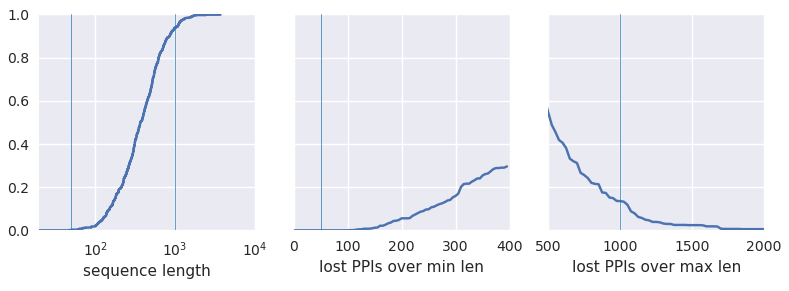

In [65]:
_huri_hash_ppis, _huri_seqs, fig = filter_ppis_and_fasta_by_len(
    huri_hash_ppis, huri_seqs, c.min_seq_len, c.max_seq_len)
len(huri_seqs), len(_huri_seqs)

#### test: save seqs + positives

In [66]:
huri_hash_ppis = _huri_hash_ppis
huri_seqs = _huri_seqs

In [67]:
_ = SeqIO.write(huri_seqs.values(), c.test_raw_fasta, 'fasta')
huri_hash_ppis.to_csv(c.test_raw_tsv, sep='\t', header=True, index=False)
c.test_raw_fasta, c.test_raw_tsv

(PosixPath('huri/huri_test_raw.fasta'), PosixPath('huri/huri_test_raw.tsv'))

In [68]:
len(train_seqs), len(val_seqs), len(huri_seqs), len(val_seqs) + len(train_seqs) + len(huri_seqs)

(7569, 628, 550, 8747)

In [69]:
len(train), len(val), len(huri_hash_ppis)

(13010, 994, 930)

## Test + validation: redundancy-reduce

Use [rostclust](https://git.rostlab.org/bernhoferm/mmseqs2-uniqueprot/-/tree/F_typer_app) to create non-redundant `test` and `validation` sets. <br> Don't run the next cells in the wrong order, and don't forget to copy the files back and forth if you are running `rostclust` elsewhere! <br>In particular, copy files after `shrink_files_both_ways`.

In [70]:
c.hval_config

{'shortAlignmentLen': 50,
 'longSeqLen': 180,
 'reduceRandomAlign': False,
 'clusterThreshold': 20}

In [71]:
with c.hval_config_path.open('w') as json_file:
    json_file.write(json.dumps(hval_config, indent=4))

The flag below allows me to test this notebook without the MMseqs2 runs. Leave `rostclust` at `False` and copy the two result files to this folder; or run `rostclust uniqueprot[2D]` from this system.

Haven't transferred these two runs to SLURM yet, sorry!

In [72]:
c.rostclust

'/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust'

In [100]:
# redundancy-reduce the validation set
run_uniqueprot(c.val_raw_fasta, c.val_rr_fasta,
               c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json apid/apid_validation_raw.fasta apid/apid_validation_rr.fasta
using temporary directory apid/apid_validation_rawtblm4ppn
extract hvals from alignments: 100%|██████████| 1/1 [00:00<00:00, 20.27it/s]
 532/628 non-redundant in apid/apid_validation_raw.fasta written to apid/apid_validation_rr.fasta


In [101]:
# cluster the test set against val
run_uniqueprot2D(c.test_raw_fasta, c.val_rr_fasta,
                 c.test_nr_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json huri/huri_test_raw.fasta apid/apid_validation_rr.fasta huri/huri_test_nr.fasta
using temporary directory huri/huri_test_rawesackzj7
extract hvals from alignments: 100%|██████████| 1/1 [00:00<00:00, 78.59it/s]
 524/550::532 non-redundant in huri/huri_test_raw.fasta against apid/apid_validation_rr.fasta written to huri/huri_test_nr.fasta


In [102]:
# cluster the test set against val
run_uniqueprot2D(c.test_raw_fasta, c.val_rr_fasta,
                 c.test_nr_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json huri/huri_test_raw.fasta apid/apid_validation_rr.fasta huri/huri_test_nr.fasta
using temporary directory huri/huri_test_rawfeti80hd
extract hvals from alignments: 100%|██████████| 1/1 [00:00<00:00, 73.02it/s]
 524/550::532 non-redundant in huri/huri_test_raw.fasta against apid/apid_validation_rr.fasta written to huri/huri_test_nr.fasta


In [103]:
# redundancy-reduce the test set
run_uniqueprot(c.test_nr_fasta, c.test_rr_fasta,
               c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json huri/huri_test_nr.fasta huri/huri_test_rr.fasta
using temporary directory huri/huri_test_nr6dknyncx
extract hvals from alignments: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]
 480/524 non-redundant in huri/huri_test_nr.fasta written to huri/huri_test_rr.fasta


In [104]:
fastalen = lambda _file: len([r.id for r in SeqIO.parse(_file, 'fasta')])

In [105]:
# also drop PPIs accordingly
assert c.test_rr_fasta.is_file()
shrink_files_both_ways(c.test_raw_tsv, c.test_rr_fasta,
                       new_tsv_name=c.test_rr_tsv)
c.test_seqs = fastalen(c.test_rr_fasta)
assert c.val_rr_fasta.is_file()
shrink_files_both_ways(c.val_raw_tsv, c.val_rr_fasta,
                       new_tsv_name=c.val_rr_tsv)
c.val_seqs = fastalen(c.val_rr_fasta)

dropped 70/550 table IDs and 246/930 rows, and 40/480 sequence IDs
dropped 96/628 table IDs and 234/994 rows, and 42/532 sequence IDs


## Prepare proteomes
#### filter by len and id

In [73]:
if c.add_proteomes:
    filter_proteomes(c.pp, c.min_seq_len, c.max_seq_len,
                     None if (hasattr(c, 'legacy') and c.legacy)
                     else c.train_raw_fasta)
# do not skip this!

100%|███████████████████████████████████████████| 15/15 [00:42<00:00,  2.80s/it]


#### run separately: faster
Separately clustering the proteomes against the test/validation set and then redundancy-reducing each one is faster and might lead to a more balanced combined proteome set that is better fit to sample from than merging all proteomes first and then running the two steps on huge files.

If available, run this on a SLURM cluster:

In [74]:
c.slurm, c.slurm_node_limit

(True, 15)

In [75]:
if c.slurm:
    import snakemake

    snakemake.snakemake(snakefile='Snakefile',
                        config=c.to_dict(),
                        nodes=c.slurm_node_limit,
                        cluster=f'sbatch -p All -N 1')

Building DAG of jobs...
Using shell: /bin/bash
Provided cluster nodes: 15
Job stats:
job                     count    min threads    max threads
--------------------  -------  -------------  -------------
all                         1              1              1
cluster_against_test        9              1              1
cluster_against_val        15              1              1
red_reduce                  7              1              1
request                     1              1              1
total                      33              1              1

Select jobs to execute...

[Fri Jan 13 22:00:29 2023]
rule cluster_against_val:
    input: swissprot/284812.fasta
    output: swissprot/284812_nr_val.fasta
    jobid: 13
    reason: Missing output files: swissprot/284812_nr_val.fasta
    wildcards: species=284812
    resources: mem_mb=1000, mem_mib=954, disk_mb=1000, disk_mib=954, tmpdir=<TBD>

Submitted job 13 with external jobid 'Submitted batch job 408105'.

[Fri Jan 13 22:00:2

#### train: cluster against val
Mind that `train_species` and `val_species` may overlap! We deal with that later.

In [76]:
s = None
if not c.slurm:
    s = rr_pattern_proteomes(
        c.train_species, c.pp, '{sp}.fasta', 'val',
        c.val_rr_fasta, c.hval_config_path, not c.rostclust)
s

#### train: cluster against test

In [77]:
if not c.slurm:
    s = rr_pattern_proteomes(
        c.train_species, c.pp, '{sp}_nr_val.fasta', 'valtest',
        c.test_rr_fasta, c.hval_config_path, not c.rostclust)
s

These `_nr_valtest.fasta` proteomes are now ready to be used as negatives for the train set!

#### val: cluster against val

In [78]:
if not c.slurm:
    # this is the same as the first call, just for different files!
    s = rr_pattern_proteomes(
        c.val_species, c.pp, '{sp}.fasta', 'val',
        c.val_rr_fasta, c.hval_config_path, not c.rostclust)
s

#### val: redundancy-reduce

In [79]:
if not c.slurm:
    # now a 1D run -> no database/reference FASTA
    s = rr_pattern_proteomes(
        c.val_species, c.pp, '{sp}_nr_val.fasta', 'val',
        None, c.hval_config_path, not c.rostclust)
s

#### val: merge

In [80]:
val_concat = c.pp / 'val_proteome_concat.fasta'
val_concat_rr = val_concat.with_stem(val_concat.stem + '_rr')

In [81]:
merge_pattern_proteomes(c.val_species, val_concat, c.pp, '{sp}_rr_val.fasta')

#### val: redundancy-reduce merged set

In [82]:
run_uniqueprot(val_concat, val_concat_rr, c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json swissprot/val_proteome_concat.fasta swissprot/val_proteome_concat_rr.fasta
using temporary directory swissprot/val_proteome_concat4ikpsbz2
extract hvals from alignments: 100%|██████████| 23/23 [00:35<00:00,  1.54s/it]
 38210/55492 non-redundant in swissprot/val_proteome_concat.fasta written to swissprot/val_proteome_concat_rr.fasta


#### test: cluster against val

In [84]:
s = None
if not c.slurm:
    s = run_uniqueprot2D(c.pp / '9606.fasta',
                         c.val_rr_fasta,
                         c.pp / '9606_nr_val.fasta',
                         c.hval_config_path, not c.rostclust)
s

#### test: cluster against test

In [85]:
if not c.slurm:
    s = run_uniqueprot2D(c.pp / '9606_nr_val.fasta',
                         c.test_rr_fasta,
                         c.pp / '9606_nr_valtest.fasta',
                         c.hval_config_path, not c.rostclust)
s

#### test: redundancy-reduce

In [86]:
if not c.slurm:
    s = run_uniqueprot(c.pp / '9606_nr_valtest.fasta', c.pp / '9606_rr_valtest.fasta',
                       c.hval_config_path, not c.rostclust)
s

The `swissprot/9606_rr_test.fasta` can be used as test set negatives directly; as this is a single-species set there is no combined set that needs redundancy reduction.

#### collate train/val/test proteomes
Create per-species dicts of potential negative interaction partners. Doing this once to save some `pull` calls.

In [87]:
train_proteome = write_json(read_hash_proteomes(
    c.train_species, c.pp, '{sp}_nr_valtest.fasta'), c.train_proteome)

100%|███████████████████████████████| 8/8 [00:22<00:00,  2.86s/it, batch=284812]


In [88]:
val_proteome = write_json(parse_val_proteome(val_concat_rr), c.val_proteome)

38210it [00:06, 5780.74it/s] 


In [89]:
# test_proteome = write_json(read_hash_proteomes(
#     {9606}, c.pp, '{sp}_rr_valtest.fasta'), c.test_proteome)

## Generate negatives: examples
Negatives are sampled *per species*. Mind that the test set is human-only!
Start with the train set!
Re-write with proteomes, but without C123 labels.

In [90]:
c.strategy, c.ratio, c.seed, c.accept_homodimers

(<SamplingStrategy.BALANCED: 1>, 10.0, 42, False)

In [91]:
train_proteome = read_json(c.train_proteome)

## APID train
#### generate negatives

In [92]:
# sanity check if there are any proteins in test that
# were already in train. re: "do not add back in identical ones"
assert not ({r.id for r in SeqIO.parse(c.train_raw_fasta, 'fasta')} & {
    r.id for r in SeqIO.parse(c.test_rr_fasta, 'fasta')})

In [93]:
train = pd.read_csv(c.train_raw_tsv, sep='\t', header=0)
train_seqs = SeqIO.to_dict(SeqIO.parse(c.train_raw_fasta, 'fasta'))
len(train), len(train_seqs)

(13010, 7569)

In [94]:
train_ppis, train_negs, train_bias, _ = make_negatives(train, c, train_proteome)

sampling negatives per species! aim for 130100


37296: 105it [00:00, 4733.77it/s]                                               
85962:   0%|                                          | 0/16120 [00:00<?, ?it/s]

37296 extras hash: ACECFBBCB4A7FF38


10116: 3904it [00:01, 3147.06it/s]                                              
243276:  14%|████                        | 3876/26800 [00:01<00:07, 2988.77it/s]

10116 extras hash: 9481BBB210EF5FD5


36329: 5363it [00:01, 3230.17it/s]                                              
83333:  13%|███▊                         | 2981/22380 [00:01<00:09, 1960.91it/s]

36329 extras hash: 843581A1C03FF239


85962: 16198it [00:07, 2238.68it/s]                                             
284812:  49%|█████████████▏             | 12041/24560 [00:07<00:07, 1744.61it/s]

85962 extras hash: 9410238CD362673F


243276: 33491it [00:12, 2650.64it/s]▍   | 19524/22380 [00:12<00:02, 1160.47it/s]


243276 extras hash: 8F8057962A0B2AA2


83333: 22396it [00:14, 1541.41it/s]                                             
284812:  87%|███████████████████████▍   | 21271/24560 [00:14<00:02, 1462.31it/s]

83333 extras hash: 21678463232CDAB8


284812: 25583it [00:17, 1448.08it/s]     | 16590/30920 [00:17<00:19, 749.84it/s]


284812 extras hash: F2D428BE4B610C8F


10090: 31389it [00:37, 846.63it/s]                                              


10090 extras hash: FD2AB14F337D0095
134180 negatives with overall 0.969 and average per-species bias of 0.990±0.019 (std)


134180 negatives with overall 0.969 and average per-species bias of 0.990±0.019 (std)

#### bias

In [95]:
c.train_bias = train_bias.set_index('species').to_dict()['bias']
train_bias.sort_values(by='bias')

,species,bias
6,243276,0.941259
3,37296,0.98159
7,284812,0.999837
5,85962,0.999878
2,36329,0.999959
1,10116,0.999965
0,10090,0.999971
4,83333,0.999979


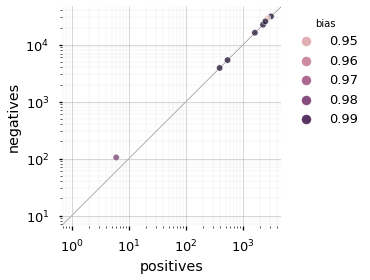

In [96]:
with mpl.rc_context({'figure.dpi': 72}):
    fig = plot_bias(train_ppis, train_negs, train_bias, c.ratio)
fig.savefig('train_bias.svg')

#### degrees
Evaluate how close the real ratio of negative : positive interactions per protein is to our target ratio

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/k/kaindll/mambaforge/envs/ppi/lib/python3.10/site-packages/seaborn/axisgrid.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


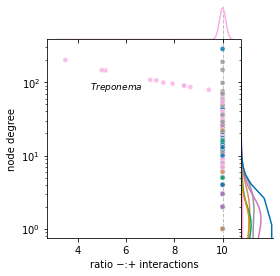

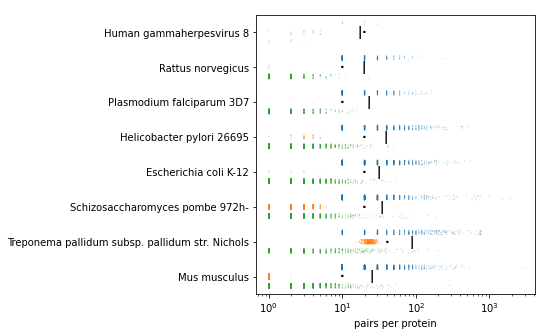

In [97]:
with mpl.rc_context({'figure.dpi': 72}):
    fig, fig2, df, nsp = plot_ratio_degree(
        train_ppis, train_negs, c.ratio, height=4, taxonomy=taxonomy)
ax = fig.axes[0]
# ax.set(xlim=(1.8, 10.5))
# ax.annotate(2697049, xy=(2.5, 2.8), size=9)
ax.annotate('$Treponema$', xy=(4.5, 80), size=9)  #243276
# ax.annotate(192222, xy=(8, 180), size=9)
fig.savefig('train_ratios.svg')
if fig2 is not None:
    fig2.savefig('train_negative_degree.svg')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/k/kaindll/mambaforge/envs/ppi/lib/python3.10/site-packages/seaborn/axisgrid.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


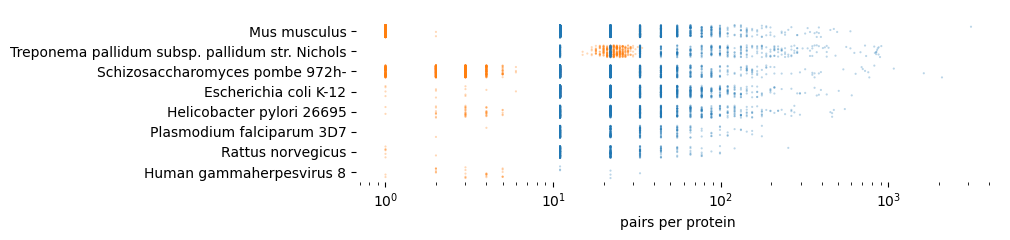

In [98]:
with mpl.rc_context({'figure.dpi': 100}):
    fg = plot_degrees_wide(train_ppis, train_negs, taxonomy, False,
                           # [3702, 7227, 284812, 10090, 192222, 10299, 632, 2697049]
                           )
fg.savefig('train_degree_wide.svg')

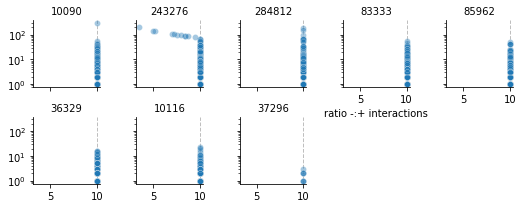

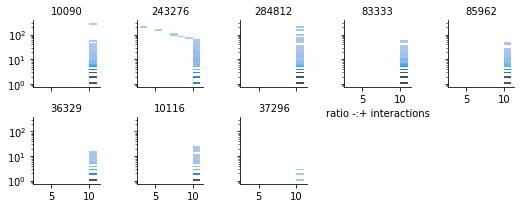

In [99]:
order = (taxonomy.loc[taxonomy.species.isin(train.species)]
             .sort_values(by='n_ppis')['species'][::-1])
with mpl.rc_context({'figure.dpi': 72}):
    g, h = plot_ratio_grids(df, order, c.ratio)

In [100]:
desc = (df  #.loc[df.degree <= 3]
        .groupby('species')
        .describe()
        ['ratio']
        .sort_values(by='count')
        .round(2)
        .convert_dtypes()
        )
desc

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
37296,7,10.0,0.0,10.0,10,10,10,10
10116,392,10.0,0.0,10.0,10,10,10,10
36329,470,10.0,0.0,10.0,10,10,10,10
243276,564,9.94,0.47,3.5,10,10,10,10
85962,835,10.0,0.0,10.0,10,10,10,10
83333,1420,10.0,0.0,10.0,10,10,10,10
284812,1448,10.0,0.0,10.0,10,10,10,10
10090,2433,10.0,0.0,10.0,10,10,10,10


#### save
The PPIs are easy:

In [101]:
train_all = pd.concat((train_ppis, train_negs))
train_all.to_csv(c.train_tsv, sep='\t', header=True, index=False)
c.train_size = len(train_all)
c.train_size, c.train_tsv

(147190, PosixPath('apid_train.tsv'))

But update the set of sequences with the added SwissProt proteins.

In [102]:
assert not set(np.unique(train_ppis.iloc[:, [0, 1]])) - train_seqs.keys()

In [103]:
train_extra = get_proteome_seqs(train_proteome, train_seqs, train_negs)
_ = SeqIO.write(values_sorted_by_key(train_extra),
                c.pp / 'train_extra.fasta', 'fasta')
train_seqs.update(train_extra)
c.train_extra = len(train_extra)
c.train_extra

2264

In [104]:
_ = SeqIO.write(values_sorted_by_key(train_seqs), c.train_fasta, 'fasta')
len(train_seqs), c.train_fasta

(9833, PosixPath('apid_train.fasta'))

In [105]:
assert len(train_all), len(train_seqs) == shrink_both_ways(
    train_all.copy(), train_seqs.copy())

## APID validation
#### generate negatives
The `val` DataFrame is not up-to-date, use the contents of `val_rr_tsv` and `val_rr_fasta` instead!

In [106]:
val = pd.read_csv(c.val_rr_tsv, sep='\t', header=0)
val_seqs = SeqIO.to_dict(SeqIO.parse(c.val_rr_fasta, 'fasta'))
len(val), len(val_seqs)

(760, 490)

In [107]:
set(val.species)

{7955, 9031, 9913, 10377, 39947, 224308}

In [108]:
val_proteome = read_json(c.val_proteome)

In [109]:
with mpl.rc_context({'figure.dpi': 64}):
    val_ppis, val_negs, val_bias, _ = make_negatives(val, c, val_proteome)

sampling negatives per species! aim for 7600


10377: 78it [00:00, 5144.28it/s]                                                
9031: 100%|███████████████████████████████████| 60/60 [00:00<00:00, 4159.78it/s]


10377 extras hash: D91F064183A99D9E


7955: 85it [00:00, 4956.22it/s]                                                 


7955 extras hash: 0FB9CE14DA4DF189


39947:   0%|                                            | 0/710 [00:00<?, ?it/s]/home/k/kaindll/mambaforge/envs/ppi/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
9913: 519it [00:00, 4806.90it/s]                                                


9913 extras hash: F53F0D162EC17BD0


39947: 729it [00:00, 4208.35it/s]                                               
224308:   9%|██▊                           | 588/6320 [00:00<00:01, 2910.51it/s]

39947 extras hash: D2254289DB8F3BCB


224308: 7380it [00:02, 2937.37it/s]                                             


224308 extras hash: 69EC7ED60DA2DD9F
8851 negatives with overall 0.996 and average per-species bias of 0.993±0.006 (std)


8851 negatives with overall 0.996 and average per-species bias of 0.993±0.006 (std)

#### bias

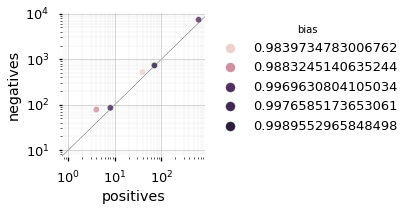

In [110]:
if type(val_bias) == np.float64:
    c.val_bias = val_bias
else:
    assert type(val_bias) == pd.DataFrame
    c.val_bias = val_bias.set_index('species').to_dict()['bias']

    with mpl.rc_context({'figure.dpi': 72}):
        fig = plot_bias(val_ppis, val_negs, val_bias, c.ratio)
    fig.savefig('val_bias.svg')

#### degrees

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/k/kaindll/mambaforge/envs/ppi/lib/python3.10/site-packages/seaborn/axisgrid.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


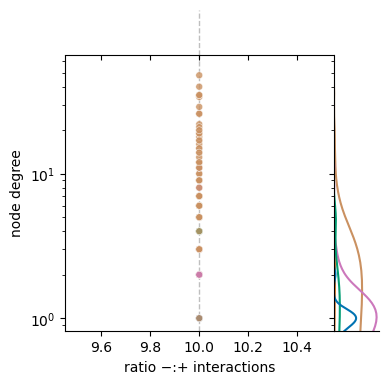

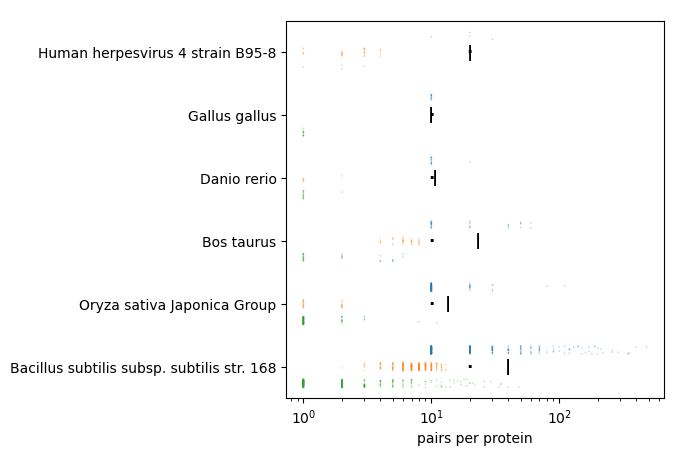

In [111]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, fig2, vdf, vnsp = plot_ratio_degree(
        val_ppis, val_negs, c.ratio, height=4, taxonomy=taxonomy)
fig.savefig('val_ratio_degree.svg')
if fig2 is not None:
    fig2.savefig(f'val_negative_degree.svg')

Are we running out of extra proteins again?

In [112]:
vdf.loc[vdf.ratio != c.ratio]

,crc_hash,degree,ratio,species


In [113]:
if 37296 in c.val_species:
    with mpl.rc_context({'figure.dpi': 64}):
        v_ppis, v_negs, v_bias, _ = make_negatives(
            val.loc[val.species == 37296].copy(), c, val_proteome)

Yes we are running out of extra (SwissProt) proteins again!

#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [114]:
val_all = pd.concat((val_ppis, val_negs))
val_all.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_size = len(val_all)
c.val_size, c.val_tsv

(9611, PosixPath('apid_validation.tsv'))

In [115]:
assert not set(np.unique(val_ppis.iloc[:, [0, 1]])) - val_seqs.keys()

In [116]:
val_extra = get_proteome_seqs(val_proteome, val_seqs, val_negs)
_ = SeqIO.write(values_sorted_by_key(val_extra),
                c.pp / 'val_extra.fasta', 'fasta')
c.val_extra = len(val_extra)
c.val_extra, len(val_seqs)

(382, 490)

In [117]:
val_seqs.update(val_extra)

In [118]:
_ = SeqIO.write(values_sorted_by_key(val_seqs), c.val_fasta, 'fasta')
len(val_seqs), c.val_fasta

(872, PosixPath('apid_validation.fasta'))

In [119]:
assert len(val_all), len(val_seqs) == shrink_both_ways(
    val_all.copy(), val_seqs.copy())

#### cluster against train
Clustering the `APID` validation set against the `APID` train set gives us **C1-3** labels for the validation set.

In [120]:
run_uniqueprot2D(c.val_fasta, c.train_fasta, c.val_c3_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json apid_validation.fasta apid_train.fasta apid/apid_validation_c3.fasta
using temporary directory apid_validationths6vsax
extract hvals from alignments: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]
 706/872::9833 non-redundant in apid_validation.fasta against apid_train.fasta written to apid/apid_validation_c3.fasta


#### label PPIs

In [121]:
val_pairs = make_c_classes(c.val_tsv, c.val_c3_fasta, c.val_fasta)

#### class sizes

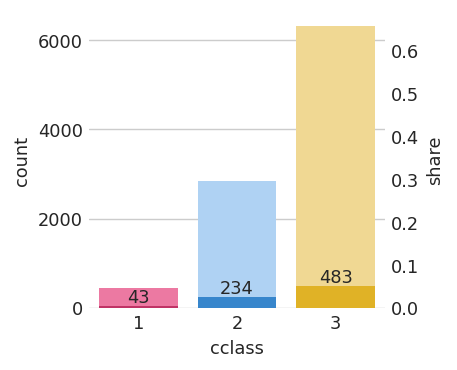

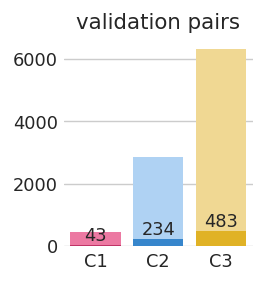

In [122]:
with mpl.rc_context({'figure.dpi': 128}):
    _, c.val_sizes = plot_c_classes(val_pairs)
    fig = small_style_cclasses(
        val_pairs, 'validation pairs', ccify=False, clabels=True)
fig.savefig(f'val_cclasses.svg')

In [123]:
# sizes of the sets of positives per species
dict(val_ppis.species.value_counts())

{224308: 632, 39947: 71, 9913: 39, 7955: 8, 9031: 6, 10377: 4}

#### save

In [124]:
if not (bak := c.val_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.val_tsv, bak)
val_pairs.to_csv(c.val_tsv, sep='\t', header=True, index=False)
c.val_tsv

PosixPath('apid_validation.tsv')

## HuRI test
#### generate negatives
Read in the files first ...

In [125]:
test = pd.read_csv(c.test_rr_tsv, sep='\t', header=0)
test_seqs = SeqIO.to_dict(SeqIO.parse(c.test_rr_fasta, 'fasta'))
len(test), len(test_seqs)

(684, 440)

In [126]:
set(test.species)

{9606}

In [127]:
# reduce the test proteome against the selected val proteome sequences
run_uniqueprot2D(c.pp / '9606_rr_valtest.fasta', c.pp / 'val_extra.fasta',
                 c.pp / '9606_rr_valtest_nr_valextra.fasta',
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json swissprot/9606_rr_valtest.fasta swissprot/val_extra.fasta swissprot/9606_rr_valtest_nr_valextra.fasta
using temporary directory swissprot/9606_rr_valtestjv1gz2dj
extract hvals from alignments: 100%|██████████| 6/6 [00:00<00:00, 42.53it/s]
 14729/14784::382 non-redundant in swissprot/9606_rr_valtest.fasta against swissprot/val_extra.fasta written to swissprot/9606_rr_valtest_nr_valextra.fasta


In [135]:
test_proteome = write_json(read_hash_proteomes(
    {9606}, c.pp, '{sp}_rr_valtest_nr_valextra.fasta'), c.test_proteome)
len(test_proteome[9606])

100%|█████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it, batch=9606]


14729

9606: 684 positives, aim for 6840 negatives


9606: 6886it [00:02, 2462.43it/s]                                               


9606: 6794/6840 interactome negatives
9606: need 25 extra proteins for 16 hubs; select 25 from 14729 additional proteins. Try to create 92 interactions, ideally 22.0 per protein.
9606 extras hash: F3D5E465C939A665
proteome interactions:
   count  mean   std  min  25%  50%  75%  max
0   25.0  3.68  1.18  1.0  3.0  4.0  4.0  6.0
9606: got 6886 negatives with bias 1.000


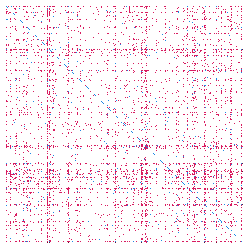

In [136]:
with mpl.rc_context({'figure.dpi': 64}):
    test_ppis, test_negatives, c.test_bias, _ = make_negatives(
        test, c, test_proteome)

In [137]:
test_ppis.head()

,hash_A,hash_B,species,label
0,CRC-001576EA78C61C85,CRC-045C9C9CAE0FD639,9606,1
1,CRC-001576EA78C61C85,CRC-12E45FF6696080F8,9606,1
2,CRC-001576EA78C61C85,CRC-2743716544288776,9606,1
3,CRC-001576EA78C61C85,CRC-2EDBC7981868EB12,9606,1
4,CRC-001576EA78C61C85,CRC-40897D5AF9B186A9,9606,1


In [138]:
test_negatives.head()

,hash_A,hash_B,species,label
0,CRC-001576EA78C61C85,CRC-00BEA89D2DC3DAD2,9606,0
1,CRC-001576EA78C61C85,CRC-03E211C0AF37B766,9606,0
2,CRC-001576EA78C61C85,CRC-0518B04A0E991529,9606,0
3,CRC-001576EA78C61C85,CRC-08F9E8BFEC42FCF3,9606,0
4,CRC-001576EA78C61C85,CRC-0B8B9168E1809B05,9606,0


#### bias
As the test set contains only single species, this is just a number

In [139]:
c.test_bias

0.9996784428598429

#### degrees

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/k/kaindll/mambaforge/envs/ppi/lib/python3.10/site-packages/seaborn/axisgrid.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


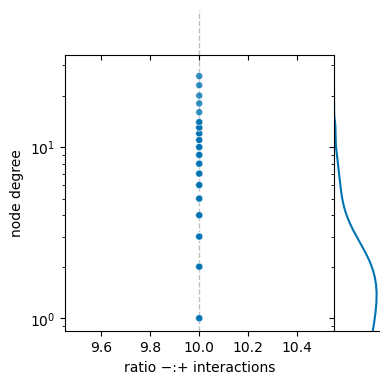

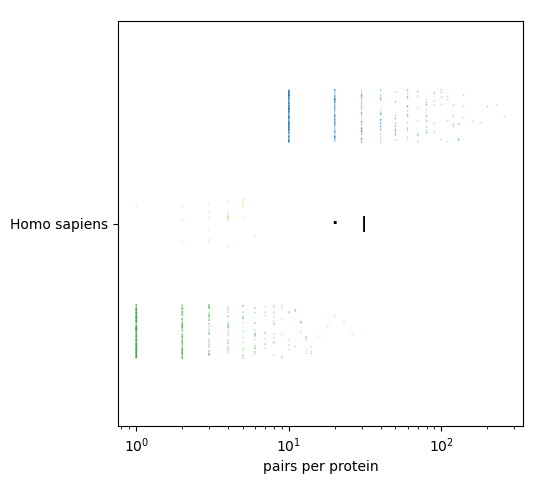

In [140]:
with mpl.rc_context({'figure.dpi': 100}):
    fig, fig2, tdf, tnsp = plot_ratio_degree(
        test_ppis, test_negatives,
        c.ratio, height=4, taxonomy=taxonomy)
fig.savefig('test_ratio_degree.svg')
if fig2 is not None:
    fig2.savefig(f'test_negative_degree.svg')

In [141]:
tdf.loc[tdf.ratio != c.ratio]

,crc_hash,degree,ratio,species


#### save
First, save the PPIs as a `TSV`. This is straightforward, but we will overwrite that file right after clustering the `FASTA`.

In [142]:
test_all = pd.concat((test_ppis, test_negatives))
test_all.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_size = len(test_all)
c.test_size, c.test_tsv

(7570, PosixPath('huri_test.tsv'))

In [143]:
assert not set(np.unique(test_ppis.iloc[:, [0, 1]])) - test_seqs.keys()

In [144]:
test_extra = get_proteome_seqs(test_proteome, test_seqs, test_negatives)
_ = SeqIO.write(values_sorted_by_key(test_extra),
                c.pp / 'test_extra.fasta', 'fasta')
c.test_extra = len(test_extra)
c.test_extra, len(test_seqs)

(25, 440)

In [145]:
test_seqs.update(test_extra)

In [146]:
_ = SeqIO.write(values_sorted_by_key(test_seqs), c.test_fasta, 'fasta')
len(test_seqs), c.test_fasta

(465, PosixPath('huri_test.fasta'))

In [147]:
assert len(test_all), len(test_seqs) == shrink_both_ways(
    test_all.copy(), test_seqs.copy())

#### cluster against train
Clustering the `HuRI` test set against the `APID` train set gives us **C1-3** labels for the test set.

In [148]:
run_uniqueprot2D(c.test_fasta, c.train_fasta, c.test_c3_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json huri_test.fasta apid_train.fasta huri/huri_test_c3.fasta
using temporary directory huri_testion0kv1i
extract hvals from alignments: 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]
 299/465::9833 non-redundant in huri_test.fasta against apid_train.fasta written to huri/huri_test_c3.fasta


#### label PPIs

In [149]:
test_pairs = make_c_classes(c.test_tsv, c.test_c3_fasta, c.test_fasta)

#### class sizes

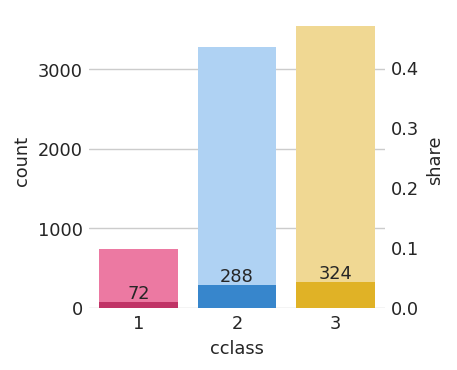

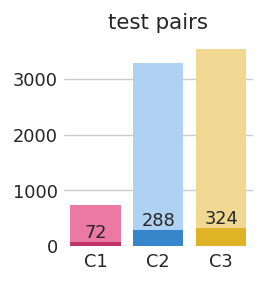

In [150]:
with mpl.rc_context({'figure.dpi': 128}):
    _, c.test_sizes = plot_c_classes(test_pairs)
    fig = small_style_cclasses(
        test_pairs, 'test pairs', ccify=False, clabels=True)
fig.savefig(f'test_cclasses.svg')

#### save

In [151]:
if not (bak := c.test_tsv.with_suffix('.tsv.bak')).is_file():
    shutil.move(c.test_tsv, bak)
test_pairs.to_csv(c.test_tsv, sep='\t', header=True, index=False)
c.test_tsv

PosixPath('huri_test.tsv')

---

In [152]:
with Path(f'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

{
  "keep_human": false,
  "keep_interspecies": false,
  "accept_homodimers": false,
  "add_proteomes": true,
  "slurm": true,
  "slurm_node_limit": 15,
  "rostclust": "/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust",
  "cwd": "/home/k/kaindll/ppi/ppi_data/results/8001",
  "ap": "apid",
  "hp": "huri",
  "qp": "apid_q1",
  "pp": "swissprot",
  "ip": "apid_isp",
  "dp": "homodimers",
  "min_seq_len": 50,
  "max_seq_len": 1000,
  "hval_config": {
    "shortAlignmentLen": 50,
    "longSeqLen": 180,
    "reduceRandomAlign": false,
    "clusterThreshold": 20
  },
  "hval_config_path": "hval_config.json",
  "seed": 42,
  "ratio": 10.0,
  "strategy": 1,
  "val_set_size": 0.1,
  "val_species": [
    9031,
    10377,
    39947,
    7955,
    224308,
    9913
  ],
  "train_species": [
    10116,
    83333,
    36329,
    10090,
    85962,
    284812,
    243276,
    37296
  ],
  "test_species": [],
  "val_raw_fasta": "apid/apid_validation_raw.fasta",
  "val_raw_tsv": "apid/apid_validation_raw

---

In [153]:
# _ = plot_test_ratios(test_pairs, c.ratio)

In [154]:
with (c.hp / 'huri.json').open('r') as json_file:
    json_hashes = {k: v for k, v in json.load(json_file).items() if v in test_seqs.keys()}
with (c.ap / 'apid.json').open('r') as json_file:
    json_hashes.update({k: v for k, v in json.load(json_file).items()
                        if v in train_seqs.keys() | val_seqs.keys()})

In [155]:
pd.DataFrame(((k, v) for k, v in json_hashes.items())).to_csv(
    'crc_hashes.tsv', sep='\t', index=False, header=False)

In [156]:
val_pairs.loc[(val_pairs.label == 0) & (val_pairs.cclass == 3)]

,hash_A,hash_B,species,label,cclass
761,CRC-13822BFBDC0C3E18,CRC-6B3DF125B7AAA830,7955,0,3
764,CRC-13822BFBDC0C3E18,CRC-A97B8C7D80E38FE8,7955,0,3
766,CRC-13822BFBDC0C3E18,CRC-BE11005D45B55706,7955,0,3
767,CRC-13822BFBDC0C3E18,CRC-D240057BE5465AE7,7955,0,3
769,CRC-13822BFBDC0C3E18,CRC-FD55AE4BFE04823C,7955,0,3
...,...,...,...,...,...
9606,CRC-F9249A49907C5A91,CRC-8FBAD9175EE8EF70,224308,0,3
9607,CRC-F9249A49907C5A91,CRC-7EEC9DFAA879AA32,224308,0,3
9608,CRC-F9249A49907C5A91,CRC-9F40E524C3452624,224308,0,3
9609,CRC-F9249A49907C5A91,CRC-EB4901978C7CC1D6,224308,0,3


DeprecationWarning: Proteins by themselves do not have a C123 class but are assigned one here! PPIs belong to a class.

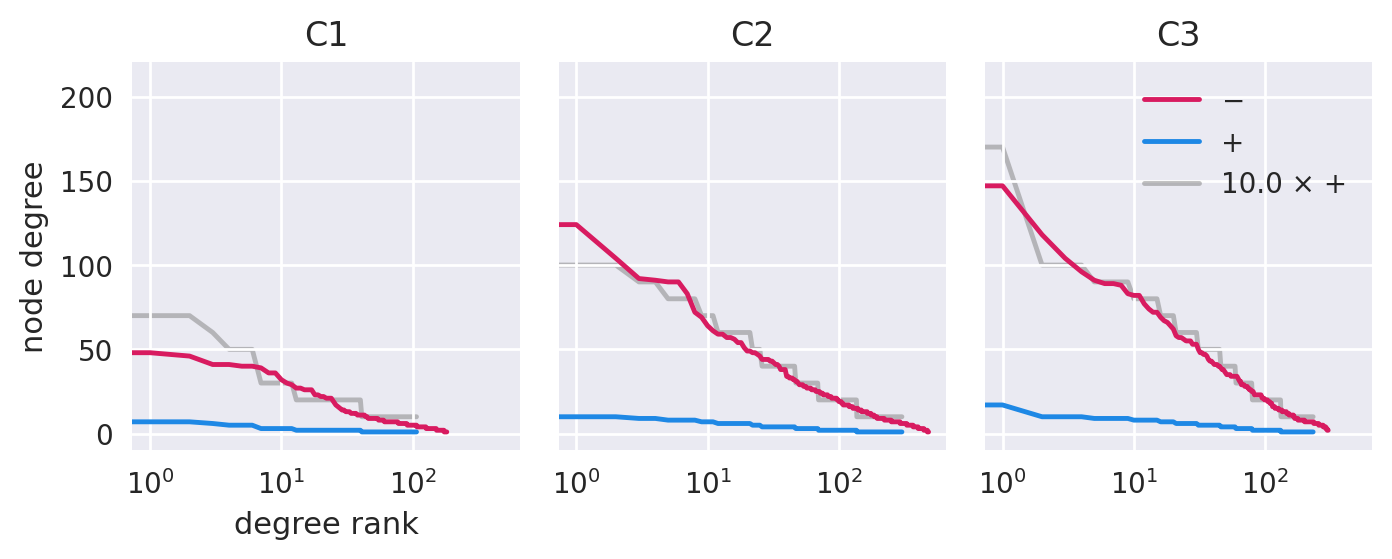

In [364]:
_ = plot_test_ratios(test_pairs, c.ratio)